# Feature importance in predicting customer retention by first-order experience

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

In [2]:
crs = pd.read_csv('~/Desktop/2023_retention_by_crs.csv')

crs.columns =crs.columns.str.replace(' ', '')

crs = crs[['CustomerRetained','2022Score','isgorgeousbox','ProductCategory','relationtoavg_category_price']]

crs.head()

,CustomerRetained,2022Score,isgorgeousbox,ProductCategory,relationtoavg_category_price
0,False,49.0,False,NaN,NaN
1,True,43.0,True,Stromboli,less
2,False,38.0,True,NaN,NaN
3,True,50.0,False,"Savory Toppings, Condiments & Spreads",more
4,False,49.0,True,NaN,NaN


## Convert dtypes


In [3]:
# Convert the categorical columns to category data type

categorical_columns = ['2022Score','ProductCategory','relationtoavg_category_price']

for col in categorical_columns:
    crs[col] = crs[col].astype("category")


# Convert the boolean columns to bool data type    
bool_columns = ['CustomerRetained','isgorgeousbox']

for col in bool_columns:
    crs[col] = crs[col].astype('bool')

# Split data


In [4]:
X = crs.drop(columns='CustomerRetained')
y = crs.CustomerRetained

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 8)



[crs.shape for nps in (X_train, X_test, y_train, y_test)]

[(53343, 5), (53343, 5), (53343, 5), (53343, 5)]

In [5]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBClassifier(random_state=8))
]


pipe = Pipeline(steps=estimators)

In [9]:
# Specify the model hyperparameters
params={ 'objective': 'binary:logistic',
        "eval_metric": "auc", #"logloss",
        "tree_method": 'hist',
        "n_estimators": 100,
        "max_depth": 5,
        "early_stopping_rounds": 10,
        "verbosity": 1
       }
clf = xgb.XGBClassifier(**params, enable_categorical=True)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# clf.save_model(Path(saved_models_path, f"xgboost_categorical_model_{current_time}.json"))

[0]	validation_0-auc:0.55259
[1]	validation_0-auc:0.55192
[2]	validation_0-auc:0.55187
[3]	validation_0-auc:0.55279
[4]	validation_0-auc:0.55356
[5]	validation_0-auc:0.55336
[6]	validation_0-auc:0.55300
[7]	validation_0-auc:0.55343
[8]	validation_0-auc:0.55425
[9]	validation_0-auc:0.55359
[10]	validation_0-auc:0.55361
[11]	validation_0-auc:0.55414
[12]	validation_0-auc:0.55446
[13]	validation_0-auc:0.55433
[14]	validation_0-auc:0.55456
[15]	validation_0-auc:0.55415
[16]	validation_0-auc:0.55425
[17]	validation_0-auc:0.55452
[18]	validation_0-auc:0.55461
[19]	validation_0-auc:0.55464
[20]	validation_0-auc:0.55474
[21]	validation_0-auc:0.55470
[22]	validation_0-auc:0.55491
[23]	validation_0-auc:0.55536
[24]	validation_0-auc:0.55556
[25]	validation_0-auc:0.55554
[26]	validation_0-auc:0.55559
[27]	validation_0-auc:0.55552
[28]	validation_0-auc:0.55560
[29]	validation_0-auc:0.55547
[30]	validation_0-auc:0.55546
[31]	validation_0-auc:0.55557
[32]	validation_0-auc:0.55556
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
clf.feature_importances_


array([0.47825   , 0.18874498, 0.2988895 , 0.03411553], dtype=float32)

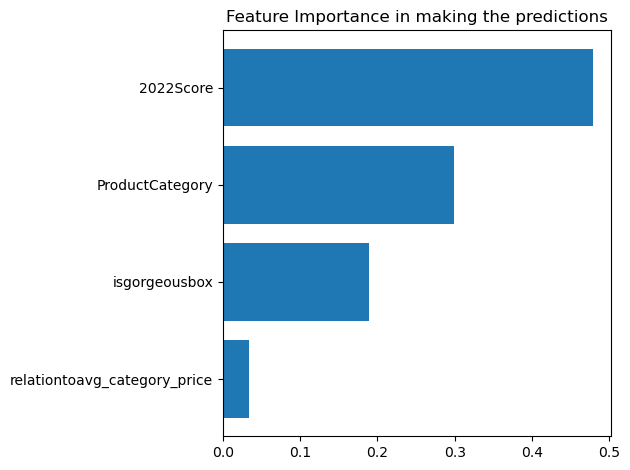

In [11]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("Feature Importance in making the predictions")
plt.tight_layout()


In [13]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf)
# shap_values = explainer(X)
shap_values = explainer(X_test)

# visualize the first observation prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=20, show=False) 

shap_values

.values =
array([[ 0.15848748, -0.03773237, -0.00893528, -0.00335849],
       [-0.05558191, -0.0558773 , -0.02876917, -0.00323662],
       [ 0.12132918,  0.06834508,  0.00320012, -0.00318787],
       ...,
       [ 0.03108893,  0.00337777,  0.00063123, -0.00340401],
       [ 0.03108893,  0.00337777,  0.00063123, -0.00340401],
       [-0.2879428 ,  0.01879776, -0.0585606 , -0.00246925]],
      dtype=float32)

.base_values =
array([-1.8160251, -1.8160251, -1.8160251, ..., -1.8160251, -1.8160251,
       -1.8160251], dtype=float32)

.data =
array([[48.0, False, nan, nan],
       [41.0, False, nan, nan],
       [32.0, False, nan, nan],
       ...,
       [37.0, False, nan, nan],
       [37.0, False, nan, nan],
       [36.0, False, nan, nan]], dtype=object)

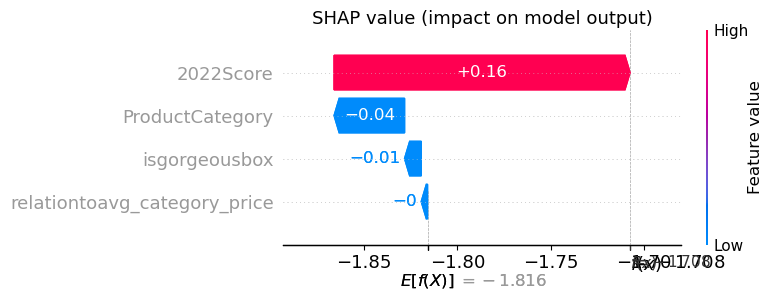

In [14]:
shap.summary_plot(shap_values, X_test, show=False) 

plt.show()